In [1]:
import binance_helpers as bh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import model as m
import ui
import importlib
import time
from datetime import datetime, timedelta
client = bh.new_binance_client()
importlib.reload(m)

<module 'model' from '/Users/SunnyNie/Documents/Investing/metagame/model.py'>

In [5]:
trades = pd.read_csv("data/trades.csv", index_col=0, parse_dates=True)
trades = trades.iloc[-3000:]

In [6]:
trades

,trades,pret,target
timestamp,,,
2021-06-01 02:00:00,wrx,0.089800,-0.006094
2021-06-01 04:00:00,cfx,0.099549,-0.041882
2021-06-01 06:00:00,sun,0.108537,0.036678
2021-06-01 08:00:00,tko,0.132762,0.002279
2021-06-01 10:00:00,dock,0.045461,0.016981
...,...,...,...
2022-02-05 16:00:00,pnt,0.131660,0.016669
2022-02-05 18:00:00,cfx,0.296118,0.080030
2022-02-05 20:00:00,poly,0.083114,-0.003911


In [7]:
t = trades.loc[(trades.target<-0.03) | (trades.target>0.03)]

In [12]:
t1 = trades.loc[trades.target>0.05]

In [9]:
def analyze(trades, func):
    result = []
    for _ in range(len(func)):
        result.append([])
    i = 0
    length = len(trades)
    for i in range(length):
        s = trades.iloc[i].name
        e = s+timedelta(hours=0)
        ss = (s-timedelta(hours=4)).strftime("%d %b %Y %H:%M:%S")
        es = (e-timedelta(hours=0, minutes=1)).strftime("%d %b %Y %H:%M:%S")
        try:
            name = trades.iloc[i].trades.upper()+"USDT"
            klines = client.get_historical_klines(symbol=name, interval = "1h", start_str=ss, end_str=es)
            btc = client.get_historical_klines(symbol="BTCUSDT", interval = "1h", start_str=ss, end_str=es)
            for j in range(len(func)):
                try:
                    result[j].append(func[j](klines, btc))
                except:
                    print(f"Warning: failed for function #{j} for trades.iloc[{i}]")
                    result[j].append(0)
        except:
            print(f"Warning: failed for trades.iloc[{i}]")
            for j in range(len(func)):
                result[j].append(0)
        i += 1
        ui.printProgressBar(i, length)
    return result

In [10]:
def abs_vol(klines, btc):
    return sum(get_index(klines, 5)[-2:])

def comp_2hr_before(klines, btc):
    vol = get_index(klines, 5)
    return sum(vol[-2:])/sum(vol)

def comp_btc(klines, btc):
    return sum(get_index(klines, 5)[-2:])/sum(get_index(btc, 5)[-2:])

def comp_hr_before(klines, btc):
    vol = get_index(klines, 5)
    return sum(vol[-1:])/sum(vol[-2:])


    
def get_index(klines, i):
    """
    1: open
    2: high
    3: low
    4: close
    5: vol
    """
    return list(map(lambda x: float(x[i]), klines))


In [11]:
result = analyze(t, [abs_vol, comp_2hr_before, comp_btc, comp_hr_before])

 |██████████████████████████████████████████████████| 100.0% 


In [13]:
df = pd.DataFrame({"abs_vol":result[0],"comp_2hr_before":result[1],"comp_btc":result[2],"comp_hr_before":result[3]}, index=t.index)


In [21]:
df['target'] = t.target

In [22]:
df.abs_vol

timestamp
2021-06-01 04:00:00    2.031179e+06
2021-06-01 06:00:00    7.071239e+04
2021-06-01 14:00:00    1.507474e+06
2021-06-01 16:00:00    3.793207e+06
2021-06-01 18:00:00    3.447089e+06
                           ...     
2022-02-05 02:00:00    2.136179e+06
2022-02-05 08:00:00    2.481037e+08
2022-02-05 12:00:00    4.137277e+05
2022-02-05 18:00:00    1.274808e+08
2022-02-06 00:00:00    3.084278e+08
Name: abs_vol, Length: 1648, dtype: float64

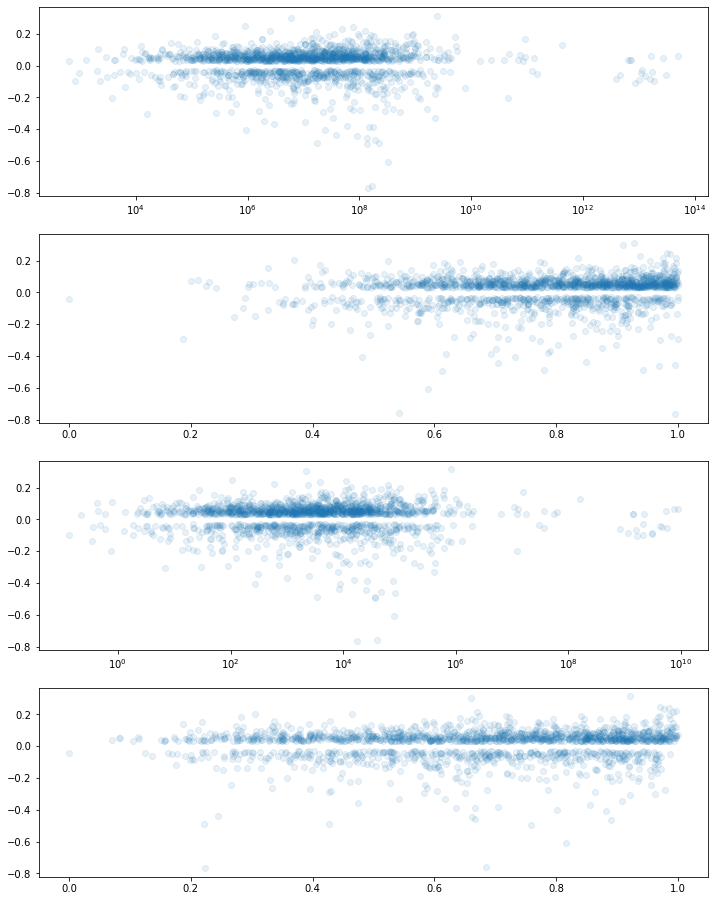

In [24]:
fig, ax = plt.subplots(4, figsize=(12, 16))
ax[0].scatter(df.abs_vol, t.target, alpha=0.1)
ax[1].scatter(df.comp_2hr_before, t.target, alpha=0.1)
ax[2].scatter(df.comp_btc, t.target, alpha=0.1)
ax[3].scatter(df.comp_hr_before, t.target, alpha=0.1)

ax[0].set_xscale('log')
ax[2].set_xscale('log')

ax[0].axhline(0, c="white", alpha=0.5)
ax[1].axhline(0, c="white", alpha=0.5)
ax[2].axhline(0, c="white", alpha=0.5)
ax[3].axhline(0, c="white", alpha=0.5)

In [34]:
df.loc[df.comp_hr_before>0.98].target

timestamp
2021-06-02 20:00:00    0.071642
2021-06-06 08:00:00    0.070010
2021-06-06 12:00:00    0.122842
2021-06-08 20:00:00    0.199376
2021-06-12 18:00:00    0.063541
2021-06-20 20:00:00   -0.046512
2021-06-27 18:00:00    0.095675
2021-07-02 08:00:00    0.061224
2021-07-11 12:00:00    0.065862
2021-07-16 16:00:00    0.049170
2021-07-20 06:00:00    0.032264
2021-07-29 22:00:00    0.103367
2021-08-07 22:00:00    0.061564
2021-08-26 00:00:00    0.121553
2021-08-30 14:00:00    0.123409
2021-09-02 18:00:00    0.043673
2021-09-13 14:00:00    0.169757
2021-09-18 06:00:00    0.053306
2021-10-01 10:00:00    0.099503
2021-10-09 14:00:00    0.213803
2021-10-21 04:00:00    0.240641
2021-10-21 08:00:00    0.219474
2021-10-26 14:00:00    0.033481
2021-10-30 08:00:00    0.081326
2021-10-31 22:00:00    0.105816
2021-11-05 10:00:00    0.051272
2021-11-30 04:00:00    0.086099
2021-12-06 16:00:00    0.121232
2021-12-08 14:00:00    0.040326
2021-12-11 12:00:00    0.060238
2021-12-18 18:00:00    0.03365

In [45]:
s

[14348.79705, 13785.38968, 12570.74769, 25618.11764]

In [46]:
s[:-2]

[14348.79705, 13785.38968]

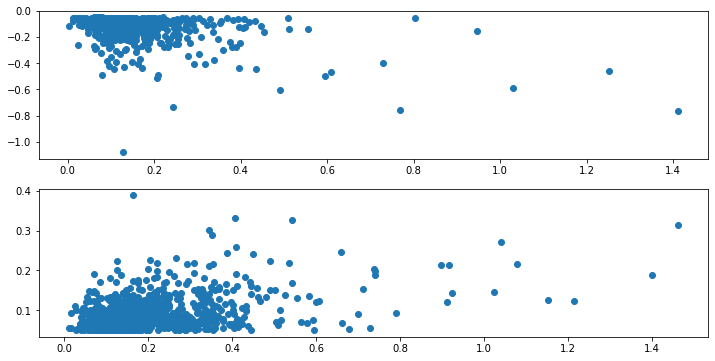

In [16]:
fig, ax = plt.subplots(2, figsize=(12, 6))
ax[0].scatter(t.pret, t.target)
ax[1].scatter(t1.pret, t1.target)